In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

459 1635
593 1635
594 1635
458 1636
459 1636
460 1636
593 1636
594 1636
459 1637
593 1637
594 1637


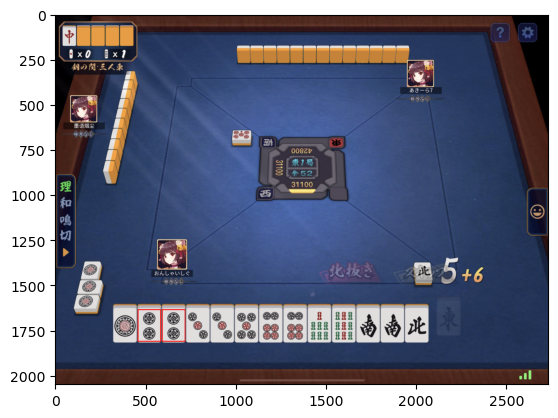

In [3]:
img_paths=[
	'dataset/1p.png',
	'dataset/2p.png',
	'dataset/3p.png', 
    'dataset/4p.png',
    'dataset/5p.png',
    'dataset/6p.png',
    'dataset/7p.png',
    'dataset/8p.png',
    'dataset/9p.png'
]
width_ipad = 2732
height_ipad = 2048

threshold = 0.8

img_bgr = cv2.imread('./dataset/input1.png')
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
template = cv2.imread(img_paths[1],0)
w, h = template.shape[::-1]

methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

res = cv2.matchTemplate(img_gray,template,cv2.TM_CCORR_NORMED)
threshold = 0.99
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_bgr, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
    print(pt[0], pt[1])

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()


In [ ]:
img_paths=[
	'dataset/1p.png',
	'dataset/2p.png',
	'dataset/3p.png', 
    'dataset/4p.png',
    'dataset/5p.png',
    'dataset/6p.png',
    'dataset/7p.png',
    'dataset/8p.png',
    'dataset/9p.png'
]

HEIGHT = 450
WIDTH = 800
OBJ_WIDTH_MIN = 50
OBJ_WIDTH_MAX = 200
TRIAL_NUM=(OBJ_WIDTH_MAX-OBJ_WIDTH_MIN)*12/5+24

THRESHOLD = 0.8
import random

## 画像をランダムサイズにリサイズ(1pixel単位)
def resize_rand_img(img,min_width,max_width):
	w_rand = random.randint(min_width,max_width)
	img_re = resize_img(img, w_rand)
	return img_re

## 画像をリサイズ
def resize_img(img,width):
	w, h = len(img[0]), len(img)
	height = h*width//w
	img_re = cv2.resize(img,(width,height))
	return img_re

## 画像をランダムに回転(1度単位)
def rot_rand_img(img):
	rot_angle = random.randint(1,360)
	img_rot = rot_img(img,rot_angle)
	return img_rot

## 画像回転
def rot_img(img,angle):
	w, h = len(img[0]), len(img)
	mat = cv2.getRotationMatrix2D(
		center=(w//2, h//2),
		angle=angle,
		scale=1)
	img_rot = cv2.warpAffine(
		img,
		mat,
		dsize=(w, h),
		borderMode=cv2.BORDER_REPLICATE)
	return img_rot

## 背景に画像をランダム位置に配置
def put_rand_img(bgimg,img,n):
	bw, bh = len(bgimg[0]), len(bgimg)
	w, h = len(img[0]), len(img)

	for _ in range(n):
		point_x = np.random.random_integers(0,bw-w)
		point_y = np.random.random_integers(0,bh-h)
		
		if np.all(
			bgimg[point_y:point_y+h, point_x:point_x+w] == (255,255,255)):
			bgimg[point_y:point_y+h, point_x:point_x+w] = img
			break
	return bgimg

## 画像の大体の色を取得
def get_mean_color(img):
	img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	_,thresh = cv2.threshold(img_gray,127,255,1)
	bgr = cv2.mean(img, mask=thresh)
	return bgr


## テスト画像を生成
def creat_test_img(imgs, min, max, density):
	bg = np.full((HEIGHT,WIDTH,3),255,np.uint8)
	for _ in range(density):
		n = random.randint(0,len(imgs)-1)
		img_resize = resize_rand_img(imgs[n],min,max)
		img_rote = rot_rand_img(img_resize)
		bg = put_rand_img(bg,img_rote, 3)
	return bg

## テンプレートマッチマッチング
def temlate_match(image,rest_img,template,threshold,rec_color,name):
	### テンプレートマッチング処理
	res = cv2.matchTemplate(rest_img,template,cv2.TM_CCOEFF_NORMED)
	loc = np.where(res >= threshold)
	w, h = len(template[0]),len(template)
	for pt in zip(*loc[::-1]):
		### 検出した領域がほぼ空白だったら無視
		detect_erea = rest_img[pt[1]+5:pt[1]+h-5,pt[0]+5:pt[0]+w-5]
		p_cnt = sum(np.where(detect_erea < 240, True, False).flatten())
		if p_cnt <= w*h/100:
			continue
		### 検出した領域の名前を描画
		cv2.putText(
			img=image,
			text=name,
			org=(pt[0]+5, pt[1]+10),
			fontFace=cv2.FONT_HERSHEY_PLAIN,
			fontScale=0.8,
			color=rec_color,
			thickness=1,
			lineType=cv2.LINE_AA)
		### 検出した領域に四角形を描画
		cv2.rectangle(image, pt, (pt[0] + w, pt[1] + h), rec_color, 1)
		### 検出した場所を複数回検知しないように消しておく。
		cv2.rectangle(rest_img, pt, (pt[0] + w, pt[1] + h), 255, -1)
	return image, rest_img

## メイン
def main():
	### 画像をロード
	img_list=[cv2.imread(img_path) for img_path in img_paths]
	### テスト画像生成
	test_image = creat_test_img(img_list,OBJ_WIDTH_MIN,OBJ_WIDTH_MAX,200)
	result_image = test_image.copy()
	
	### グレースケール化
	test_img_gray =  cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
	imgs_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in img_list]

	### テンプレートの大体の色を取得(結果描画用)
	imgs_mcolor = [ get_mean_color(img) for img in img_list]

	### テンプレートのサイズを変えながらテンプレートマッチングを繰り返す
	for i in range(OBJ_WIDTH_MIN,OBJ_WIDTH_MAX+10,10):
		templates = [resize_img(img_gray,i) for img_gray in imgs_gray]
		### テンプレートを回転せながらテンプレートマッチングを繰り返す
		for j in range(0,360,15):
			templates = [rot_img(template,j) for template in templates]
			### それぞれの種類のテンプレートで処理を行う
			for k, template in enumerate(templates):
				result_image, test_img_gray = temlate_match(
					result_image,
					test_img_gray,
					template,
					THRESHOLD,
					imgs_mcolor[k],
					'image{}'.format(k))
			### そこそこ時間がかかる(20~30秒くらい)ので進捗率を表示
			try: cnt
			except NameError: cnt = 0
			cnt += 1
			print('\r{:.1%}'.format(cnt/TRIAL_NUM),end="")
	print('\n完了')
	
	### 結果を描画
	cv2.imshow('result',result_image)
	key=cv2.waitKey(0)
	### s/Sキーで結果とテスト画像を保存
	if chr(key) == 's' or chr(key) == 'S':
		cv2.imwrite('test.png',test_image)
		print('test.pngを保存しました。')
		cv2.imwrite('result.png',result_image)
		print('result.pngを保存しました。')
	cv2.destroyAllWindows()

if __name__ == '__main__':
	main()

/var/folders/rh/ygz3cmps1ydd7dp499k6lr9w0000gn/T/ipykernel_4934/3558783445.py:61: DeprecationWarning: This function is deprecated. Please call randint(0, 659 + 1) instead
  point_x = np.random.random_integers(0,bw-w)
/var/folders/rh/ygz3cmps1ydd7dp499k6lr9w0000gn/T/ipykernel_4934/3558783445.py:62: DeprecationWarning: This function is deprecated. Please call randint(0, 228 + 1) instead
  point_y = np.random.random_integers(0,bh-h)
/var/folders/rh/ygz3cmps1ydd7dp499k6lr9w0000gn/T/ipykernel_4934/3558783445.py:61: DeprecationWarning: This function is deprecated. Please call randint(0, 703 + 1) instead
  point_x = np.random.random_integers(0,bw-w)
/var/folders/rh/ygz3cmps1ydd7dp499k6lr9w0000gn/T/ipykernel_4934/3558783445.py:62: DeprecationWarning: This function is deprecated. Please call randint(0, 297 + 1) instead
  point_y = np.random.random_integers(0,bh-h)
/var/folders/rh/ygz3cmps1ydd7dp499k6lr9w0000gn/T/ipykernel_4934/3558783445.py:61: DeprecationWarning: This function is deprecated. P

100.0%
完了
